For this notebook we will use a dedicated environment called "l2rpn_neurips_2020_track1" and "l2rpn_neurips_2020_track2", whihc have 36 and 112 substations respectively. Grid2op comes with many different environments, with different problems etc. In this notebook, we will only mention and explain these specific environment.

Power system have one major objective: allow the transmission of electricity from the producers to the consumers as effeciently as possible.



### Create a grid2op environment

In [14]:
# importing grid2op and necessary library

import grid2op
from grid2op.PlotGrid import PlotMatplot
import numpy as np # recommended

import gym
from grid2op.gym_compat import GymEnv

import os
import sys

import warnings
warnings.filterwarnings("ignore")


In [117]:
env = grid2op.make("l2rpn_neurips_2020_track1", test=True)  # i do a test, i set "Test=True" otherwise i don't specify anything
max_iter = 50                                                # we limit the number of iterations to reduce computation time. 
                                                            #Put -1 if you don't want to limit it
env.seed(42)
obs = env.reset()

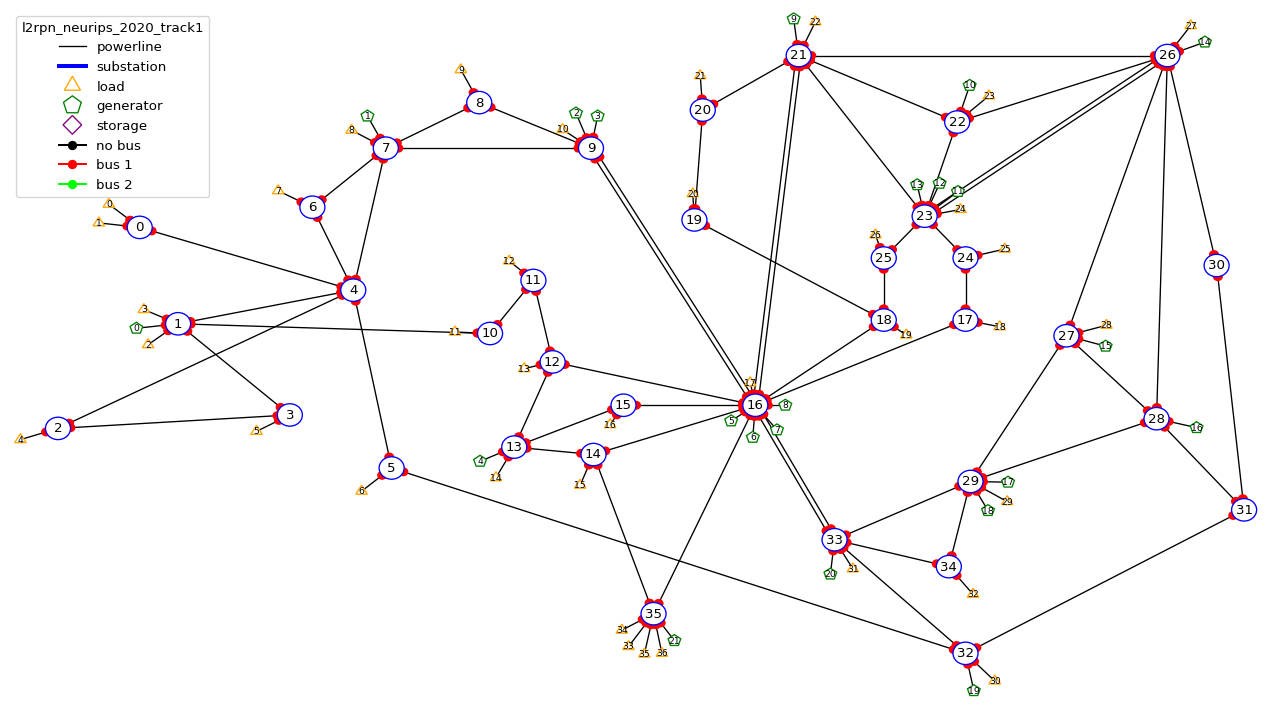

In [16]:
# %matplotlib inline
# Plotting the grid structure

from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)

_ = plot_helper.plot_layout()



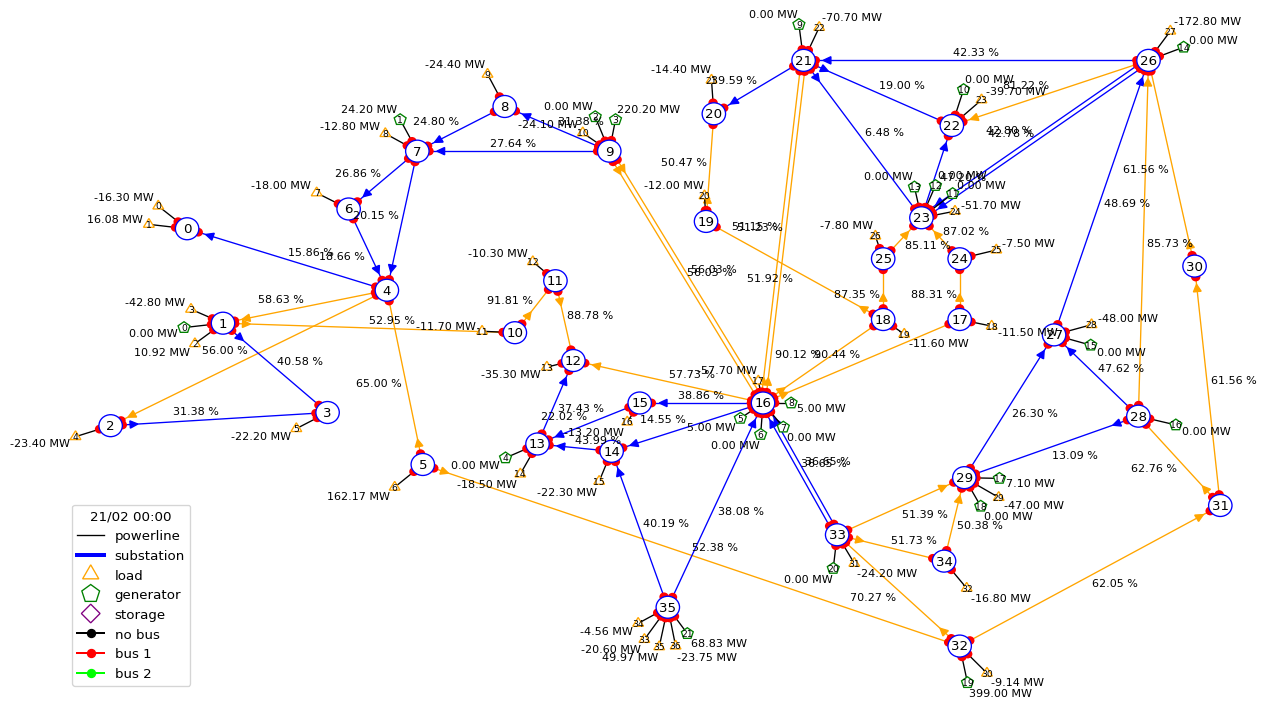

In [17]:
# plotting the observation of environment

_ = plot_helper.plot_obs(obs)

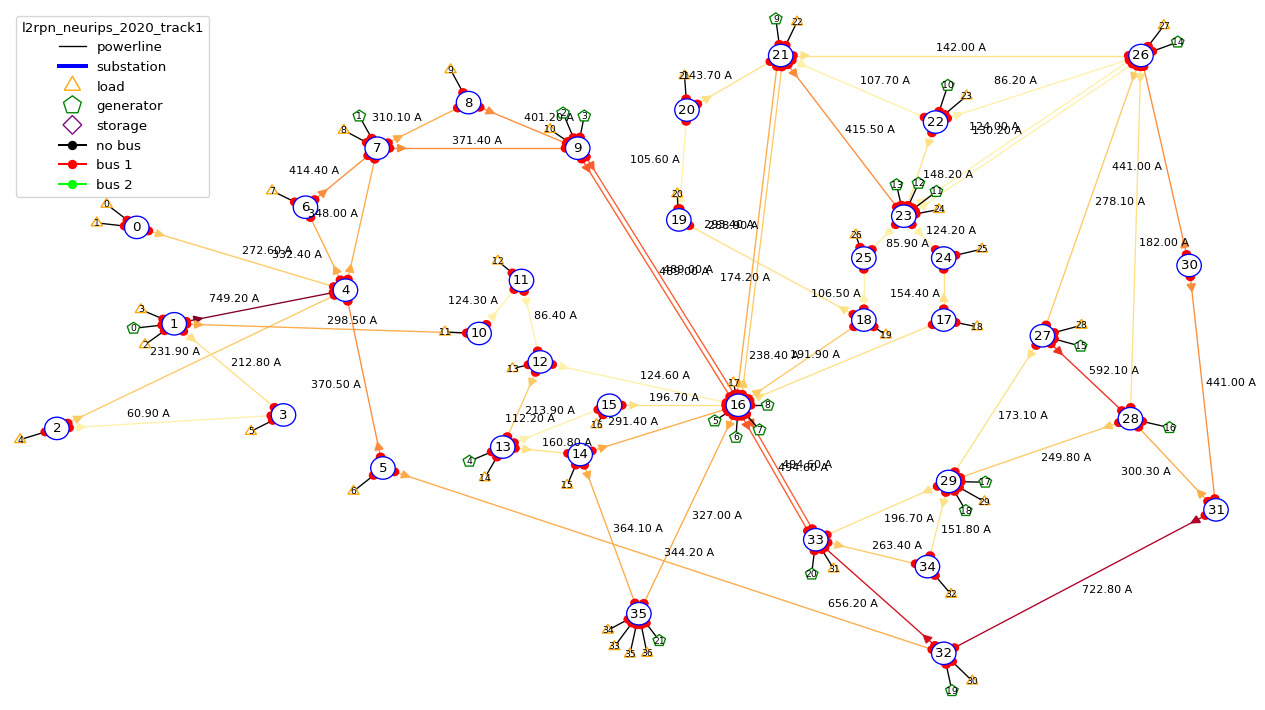

In [32]:
#Thermal Limits and Protection
# get a prettier coloring for the powerlines

plot_helper.assign_line_palette()  
_ = plot_helper.plot_info(line_values=env.get_thermal_limit(), coloring="line", line_unit="A")
plot_helper.restore_line_palette()

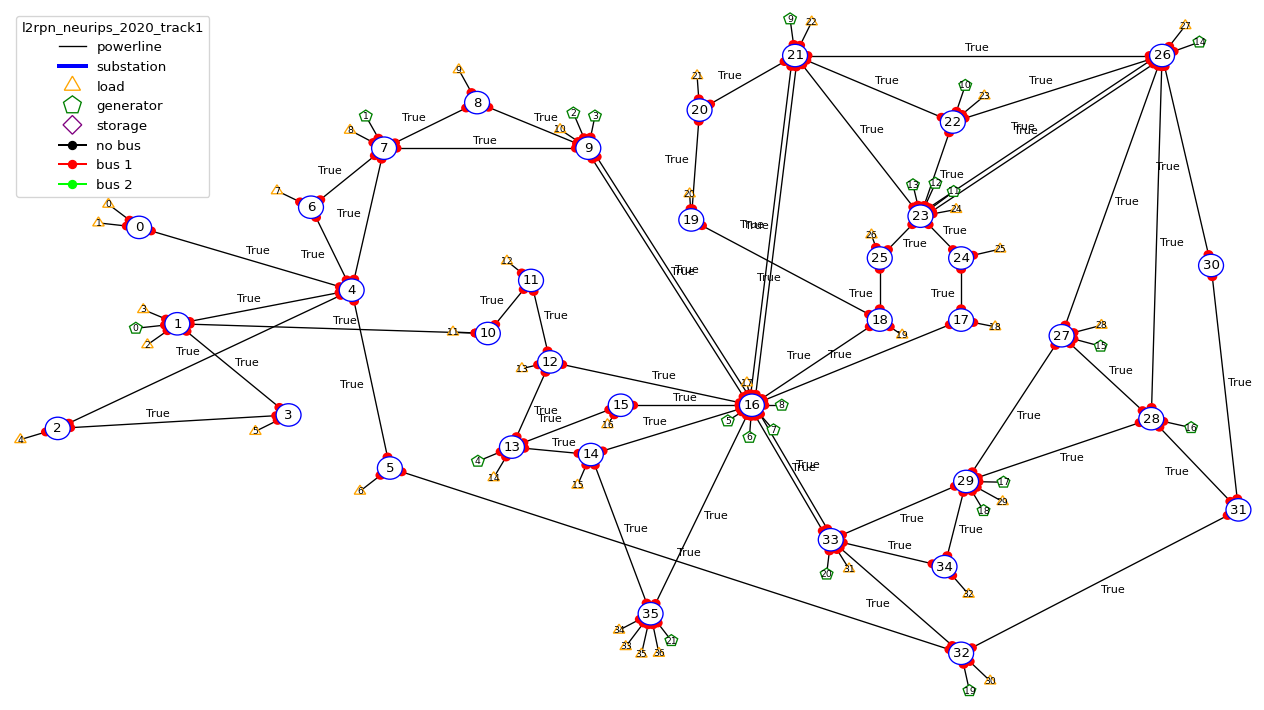

In [41]:
 # plot of line status "True" means it connected, "False means its not"
    value = env.get_current_line_status()
 _ = plot_helper.plot_info(line_values=value)

In [42]:
# lets see the rho = Power flow in each line
obs.rho

array([0.31377852, 0.5600127 , 0.15855335, 0.4057644 , 0.5862597 ,
       0.18658288, 0.20145272, 0.2685927 , 0.24795666, 0.27644113,
       0.3138066 , 0.9180667 , 0.5294881 , 0.8878102 , 0.3742951 ,
       0.43989694, 0.22024593, 0.14553857, 0.5602718 , 0.5602718 ,
       0.57731986, 0.38859782, 0.9043641 , 0.9011638 , 0.5192306 ,
       0.5046832 , 0.3959275 , 0.51153374, 0.512311  , 0.18998308,
       0.0647793 , 0.47196624, 0.8701534 , 0.8830821 , 0.8510703 ,
       0.87347233, 0.4233354 , 0.4280367 , 0.42779952, 0.8122134 ,
       0.4868938 , 0.8572547 , 0.47619298, 0.26300284, 0.1308918 ,
       0.61561906, 0.5238289 , 0.62050134, 0.3665078 , 0.3665078 ,
       0.5138606 , 0.5038482 , 0.5173305 , 0.4019473 , 0.3808247 ,
       0.64998305, 0.61561906, 0.6276469 , 0.70270604], dtype=float32)

### Information contained in an Observation

Grid2Op allows to model different kinds of observations. For example, some observations could have incomplete data, or noisy data, etc. As follows we will detail only the "CompleteObservation". CompleteObservation gives the full state of the powergrid, without any noise. It's the default type of observation used.

In [44]:
print("Number of generators of the powergrid: {}".format(obs.n_gen))
print("Number of loads of the powergrid: {}".format(obs.n_load))
print("Number of powerline of the powergrid: {}".format(obs.n_line))
print("Number of elements connected to each substations in the powergrid: {}".format(obs.sub_info))
print("Total number of elements: {}".format(obs.dim_topo))


print("Generators active production: {}".format(obs.gen_p))

print("Generators reactive production: {}".format(obs.gen_q))

print("Generators voltage setpoint : {}".format(obs.gen_v))


print("Loads active consumption: {}".format(obs.load_p))
print("Loads reactive consumption: {}".format(obs.load_q))
print("Loads voltage (voltage magnitude of the bus to which it is connected) : {}".format(obs.load_v))

Number of generators of the powergrid: 22
Number of loads of the powergrid: 37
Number of powerline of the powergrid: 59
Number of elements connected to each substations in the powergrid: [ 3  6  3  3  6  3  3  6  3  7  3  3  4  5  4  3 17  3  4  3  3  8  5 10
  3  3  9  5  5  7  2  3  5  7  3  7]
Total number of elements: 177
Generators active production: [  0.       24.2       0.      220.2       0.        5.        0.
   0.        5.        0.        0.        0.        0.        0.
   0.        0.        0.        7.1       0.      399.        0.
  68.83089]
Generators reactive production: [ -24.315086   15.679497   -4.047815  -20.239075   39.070023   18.068659
   20.076109   20.076109   18.068659   71.43525    34.433784   13.766469
   13.766469   36.8748     62.04455    39.203197  -28.571083   19.93785
   22.152971  237.85919  -224.14299  -209.74612 ]
Generators voltage setpoint : [147.8     147.8     147.8     147.8     147.8     147.8     147.8
 147.8     147.8     147.8     147.

Converting grid2op actions into "machine readable" ones is the major difficulty as there is no unique ways to do so. In grid2op we offer some pre defined "functions" to do so:

BoxGymObsSpace will convert the action space into a gym "Box". It is rather straightforward, especially for continuous type of actions (such as redispatching, curtailment or actions on storage units). Representing the discrete actions (on powerlines and on substation) is not an easy task with them. We would not recommend to use them if your focus is on topology. More information on https://grid2op.readthedocs.io/en/latest/gym.html#grid2op.gym_compat.BoxGymActSpace

MultiDiscreteActSpace is similar to BoxGymObsSpace but mainly focused on the discrete actions (lines status and substation reconfiguration). Actions are represented with a gym "MultiDiscrete" space. It allows to perform any number of actions you want (which might be illegal) but comes with little restrictions. It handles continuous actions through "binning" (which is not ideal but doable). We recommend using this transformation if the algorithm you want to use is able to deal with "MultiDiscrete" gym action type. More information is given at https://grid2op.readthedocs.io/en/latest/gym.html#grid2op.gym_compat.MultiDiscreteActSpace

DiscreteActSpace is similar to MultiDiscreteActSpace in the sense that it focuses on discrete actions. It comes with a main restriction though: you can only do one action. For example, you cannot "modify a substation" AND "disconnect a powerline" with the same action. More information is provided at https://grid2op.readthedocs.io/en/latest/gym.html#grid2op.gym_compat.DiscreteActSpace. We recommend to use it if you want to focus on discrete actions and the algorithm you want to use is not able to deal with MultiDiscreteActSpace.

You can also fully customize the way you "represent" the action. More information is given in the notebook 11_IntegrationWithExistingRLFrameworks

### Conversting to gym environment

In [59]:
env_gym = GymEnv(env)
print(f"The \"env_gym\" is a gym environment: {isinstance(env_gym, gym.Env)}")
obs_gym = env_gym.reset()
# obs_gym

The "env_gym" is a gym environment: True


#### Customize the action space and observation space

This step is optional, but highly recommended.

By default, grid2op actions and observations are huge. Even for this very simplistic example, you have really important sizes:

In [60]:
dim_act_space = np.sum([np.sum(env_gym.action_space[el].shape) for el in env_gym.action_space.spaces])
print(f"The size of the action space is : "
      f"{dim_act_space}")
dim_obs_space = np.sum([np.sum(env_gym.observation_space[el].shape).astype(int) 
                        for el in env_gym.observation_space.spaces])
print(f"The size of the observation space is : "
      f"{dim_obs_space}")

The size of the action space is : 494
The size of the observation space is : 1260


In [61]:
# example: ignore the "set_status" and "set_bus" type of actions, that are covered by the "change_status" and
# "change_bus"

# env_gym.action_space = env_gym.action_space.ignore_attr("set_line_status").ignore_attr("set_bus")

new_dim_act_space = np.sum([np.sum(env_gym.action_space[el].shape) for el in env_gym.action_space.spaces])
print(f"The new size of the action space is : {new_dim_act_space}")

The new size of the action space is : 494


Grid2op environments allow for both continuous and discrete action. For the sake of the example, let's "convert" the continuous actions in discrete ones (this is done with "binning" the values as explained in more details in the documentation )

Though it is possible to use every type of action with this type of action space, be aware that this is not recommended at all to use it for discrete attribute (set_bus, change_bus, set_line_status or change_line_status) !

Basically, when doing action in gym for these attributes, this converter will involve rounding and is definitely not the best representation. Prefer the MultiDiscreteActSpace or the DiscreteActSpace classes.

In [62]:
# example: convert the continuous action type "redispatch" to a discrete action type
from grid2op.gym_compat import ContinuousToDiscreteConverter
env_gym.action_space = env_gym.action_space.reencode_space("redispatch",
                                                           ContinuousToDiscreteConverter(nb_bins=11)
                                                           )

### Customize the observation space

For the obsevation space, we will remove lots of useless attributes (remember, it is for the sake of the example here, and rescale some other so that they have numbers between rougly 0. and 1., which stabilizes the learning process.

In [63]:
env_gym.observation_space

Dict(a_ex:Box([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf], (59,), float32), a_or:Box([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf], (59,), float32), actual_dispatch:Box([ -50.   -67.2  -50.  -250.   -50.   -33.6  -37.3  -37.3  -33.6  -74.7
 -10

Let's keep only the information about the flow on the powerlines: rho, the generation gen_p, the load load_p and the representation of the topology topo_vect (for the sake of the example, once again)

In [64]:
env_gym.observation_space = env_gym.observation_space.keep_only_attr(["rho", "gen_p", "load_p", "topo_vect", 
                                                                      "actual_dispatch"])
new_dim_obs_space = np.sum([np.sum(env_gym.observation_space[el].shape).astype(int) 
                        for el in env_gym.observation_space.spaces])
print(f"The new size of the observation space is : "
      f"{new_dim_obs_space} (it was {dim_obs_space} before!)")

The new size of the observation space is : 317 (it was 1260 before!)


In [66]:
from grid2op.gym_compat import ScalerAttrConverter
from gym.spaces import Box
ob_space = env_gym.observation_space
ob_space = ob_space.reencode_space("actual_dispatch",
                                   ScalerAttrConverter(substract=0.,
                                                       divide=env.gen_pmax
                                                       )
                                   )
ob_space = ob_space.reencode_space("gen_p",
                                   ScalerAttrConverter(substract=0.,
                                                       divide=env.gen_pmax
                                                       )
                                   )
ob_space = ob_space.reencode_space("load_p",
                                  ScalerAttrConverter(substract=obs_gym["load_p"],
                                                      divide=0.5 * obs_gym["load_p"]
                                                      )
                                  )

# for even more customization, you can use any functions you want !
shape_ = (env.dim_topo, env.dim_topo)
env_gym.observation_space.add_key("connectivity_matrix",
                                  lambda obs: obs.connectivity_matrix(),  # can be any function returning a gym space
                                  Box(shape=shape_,
                                      low=np.zeros(shape_),
                                      high=np.ones(shape_),
                                    )  # this "Box" should represent the return type of the above function
                                  )
env_gym.observation_space = ob_space
env_gym.observation_space

Dict(actual_dispatch:Box([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], (22,), float32), gen_p:Box([-14.697799  -10.935863  -14.697799   -2.9395597 -14.697799  -21.871725
 -19.702145  -19.702145  -21.871725   -9.837885   -7.3488994 -19.702145
 -19.702145   -7.3488994  -9.837885   -9.837885   -4.8992662 -10.935863
  -9.837885   -1.8372248  -2.4496331  -2.0996857], [15.697799  11.9358635 15.697799   3.9395597 15.697799  22.871725
 20.702143  20.702143  22.871725  10.837885   8.3489    20.702143
 20.702143   8.3489    10.837885  10.837885   5.8992662 11.9358635
 10.837885   2.8372247  3.449633   3.0996854], (22,), float32), load_p:Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf inf inf inf

### How to perform actions

### 3 types of actions:
- Changing the status of a powerline
- Changing the topology of a substation
- Changing the setpoint of generator

###  I - Change the status of the powerline

The first type of action is the switching on / off of powerline.

This is rather easy to do in grid2op :-)

cost of the action: 0

cooldown: 3 time steps (for the affected lines)

maximum: maximum 1 powerline affected per action

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - Force disconnection of 1 powerlines ([13])
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration
I need to wait 3 timesteps before using this line again
Be carefull, powerline 0 is in overflow for 0 timestep


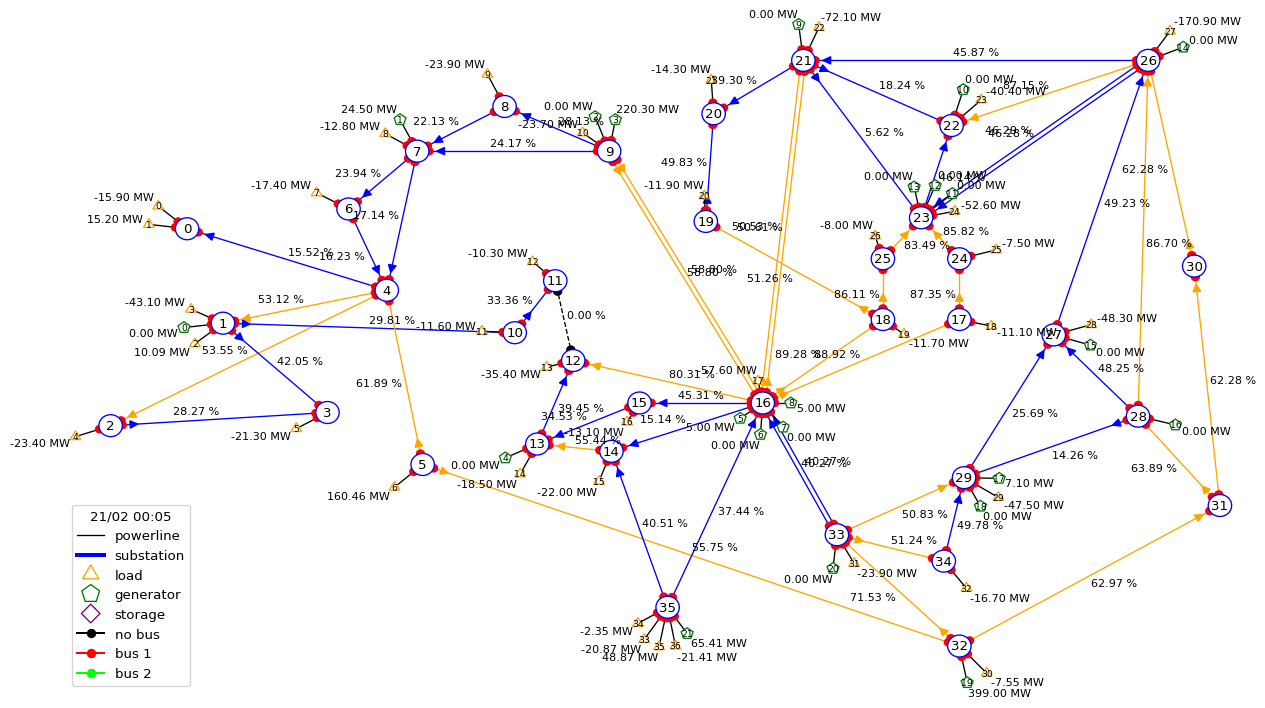

In [67]:
l_id = 13
disconnect_line_3 = env.action_space({"set_line_status": [(l_id, -1)]})
print(disconnect_line_3)
next_obs, reward, done, extra_information = env.step(disconnect_line_3)
_ = plot_helper.plot_obs(next_obs)

print("I need to wait {} timesteps before using this line again".format(next_obs.time_before_cooldown_line[l_id]))
print("Be carefull, powerline 0 is in overflow for {} timestep".format(next_obs.timestep_overflow[0]))

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - Force reconnection of 1 powerlines ([13])
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration
Was this action illegal? True
I need to wait 2 timesteps before using this line again
Be carefull, powerline 0 is in overflow for 0 timestep


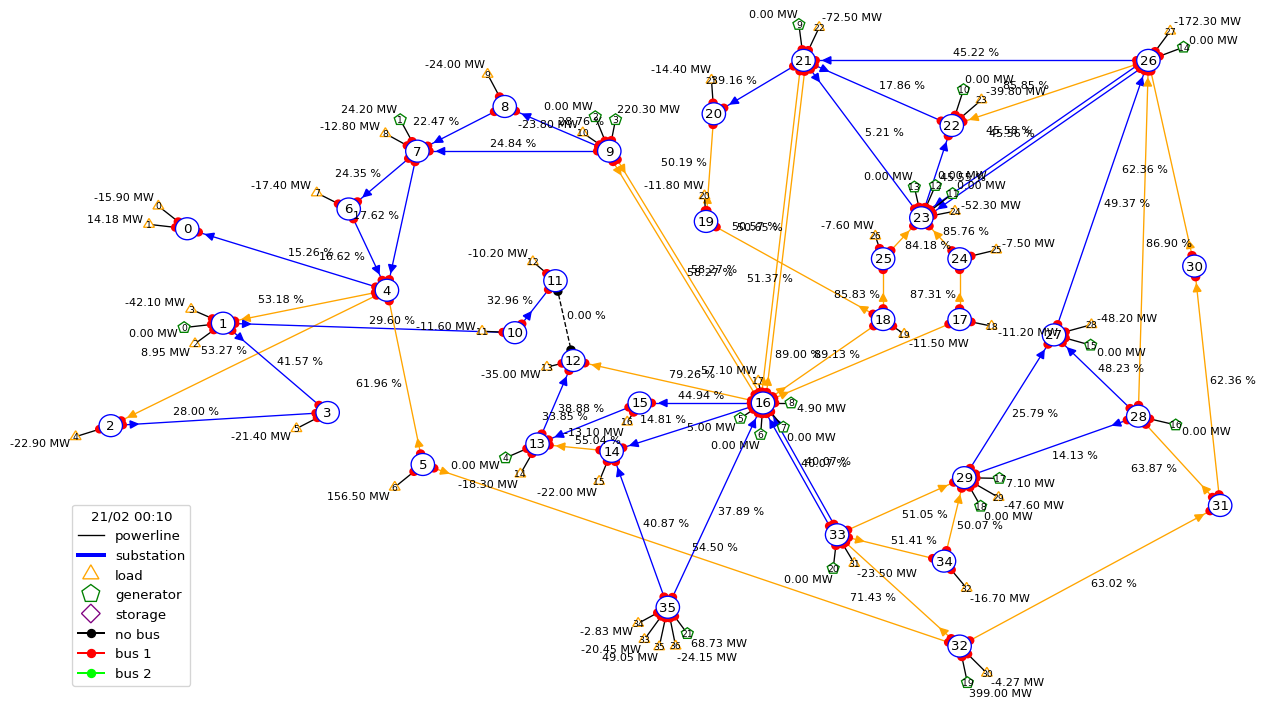

In [68]:
reconnect_line_3 = env.action_space({"set_line_status": [(l_id, +1)]})
print(reconnect_line_3)
next_obs1, reward1, done1, extra_information1 = env.step(reconnect_line_3)
_ = plot_helper.plot_obs(next_obs1)
print("Was this action illegal? {}".format(extra_information1["is_illegal"]))
print("I need to wait {} timesteps before using this line again".format(next_obs1.time_before_cooldown_line[l_id]))
print("Be carefull, powerline 0 is in overflow for {} timestep".format(next_obs1.timestep_overflow[0]))

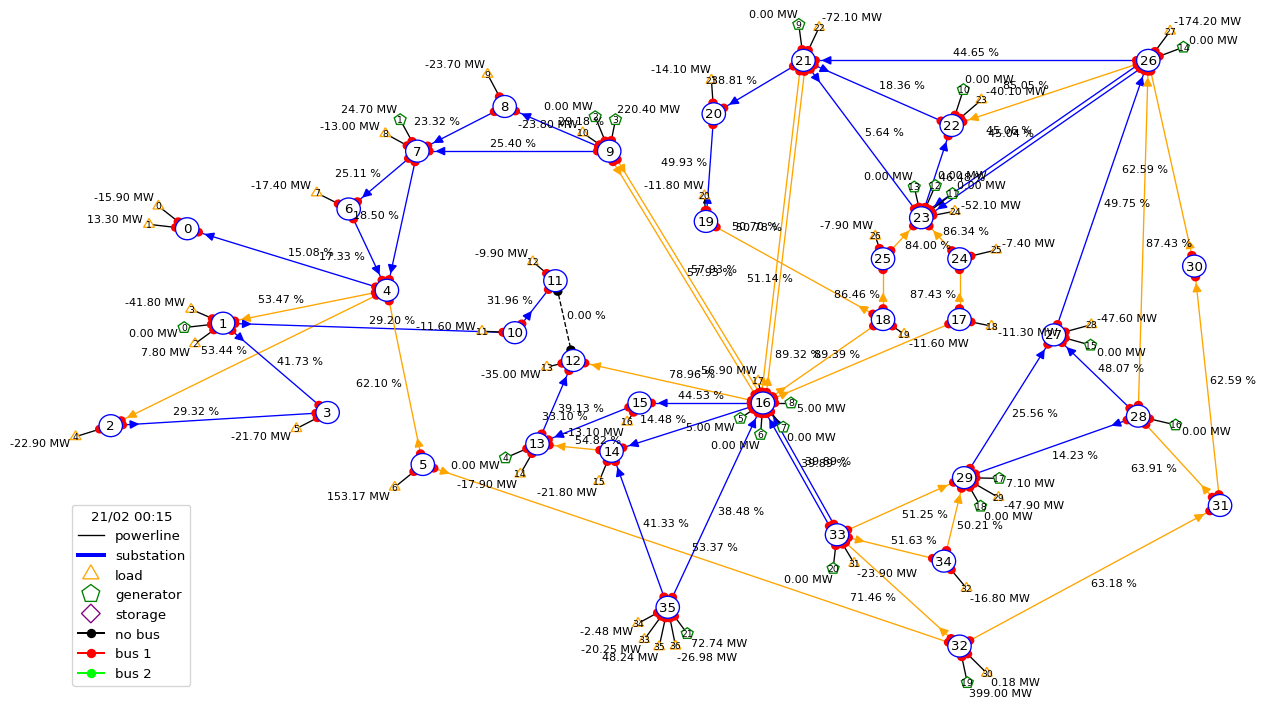

In [69]:
do_nothing = env.action_space()
next_obs2, reward2, done2, extra_information2 = env.step(do_nothing)
_ = plot_helper.plot_obs(next_obs2)

Is the game over? False


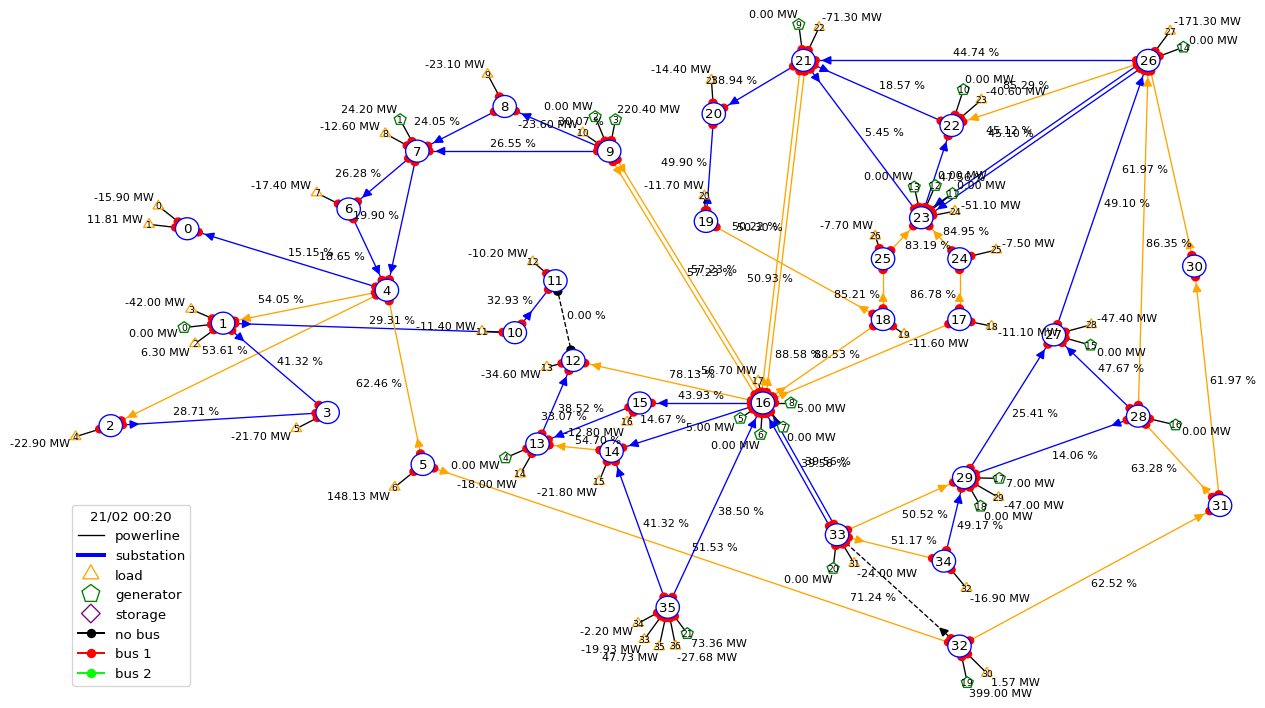

In [70]:
next_obs3, reward3, done3, extra_information3 = env.step(do_nothing)
print("Is the game over? {}".format(done3))
# plot the "last" observation
next_obs3.line_status[extra_information3["disc_lines"]] = False
_ = plot_helper.plot_obs(next_obs3)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - Force reconnection of 1 powerlines ([13])
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration
Was this action illegal? True
I need to wait 0 timesteps before using this line again
Be carefull, powerline 0 is in overflow for 0 timestep


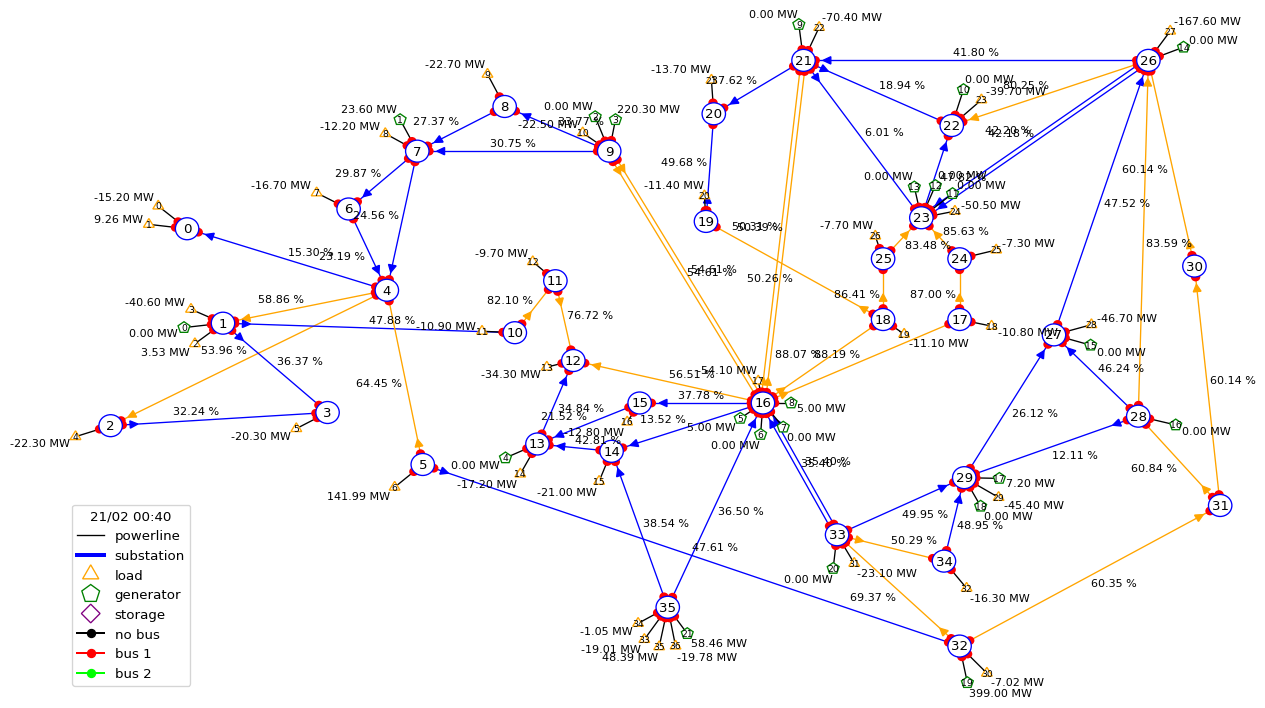

In [74]:
reconnect_line_3 = env.action_space({"set_line_status": [(l_id, +1)]})
print(reconnect_line_3)
next_obs1, reward1, done1, extra_information1 = env.step(reconnect_line_3)
_ = plot_helper.plot_obs(next_obs1)
print("Was this action illegal? {}".format(extra_information1["is_illegal"]))
print("I need to wait {} timesteps before using this line again".format(next_obs1.time_before_cooldown_line[l_id]))
print("Be carefull, powerline 0 is in overflow for {} timestep".format(next_obs1.timestep_overflow[0]))

### II - Change the topology of a given substation

Changing the topology

cost of the action: 0

cooldown: 3 time steps (for the affected substation)

maximum: 1 substation affected per action (regardless of the element changed)

Topology can also, in some cases save the situation for free (just changing some switches) here is an example.

Let's imagine for some reason the powerline from 4 to 5 is disconnected, for example a light storm hit it. Suppose, for the sake of the example that this powerline will be out of order for a few days, meaning you cannot reconnect it.

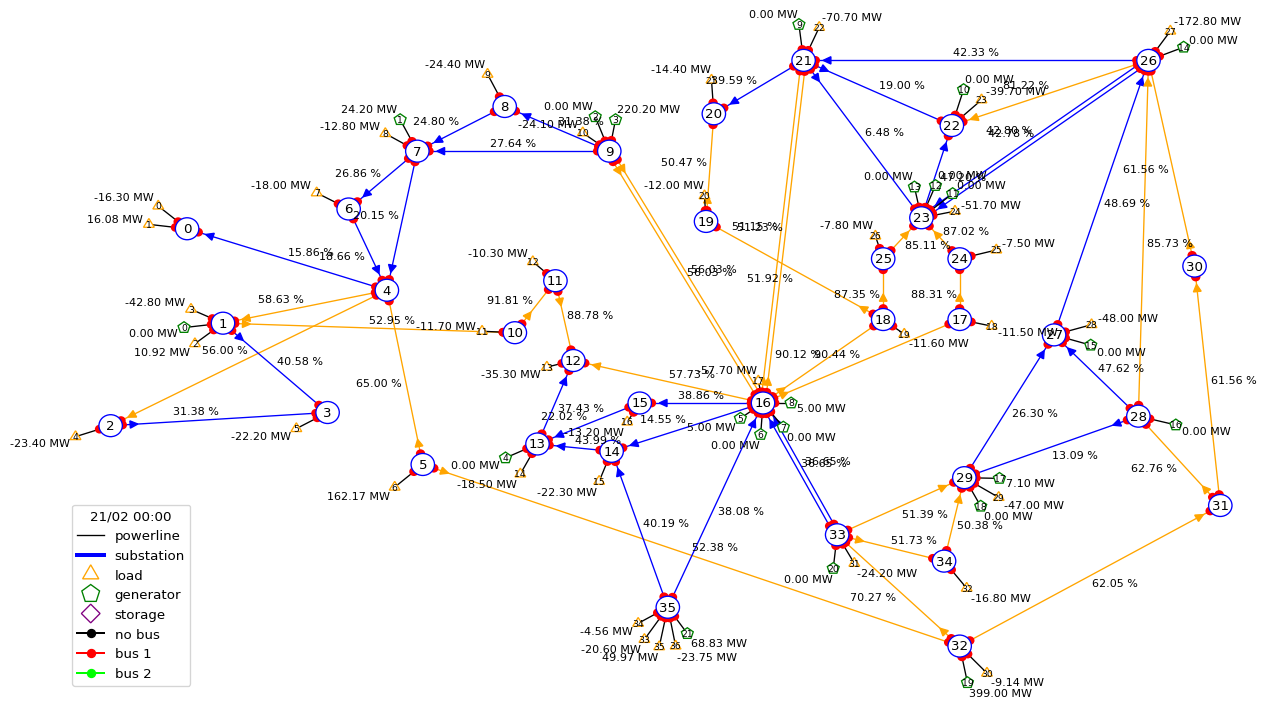

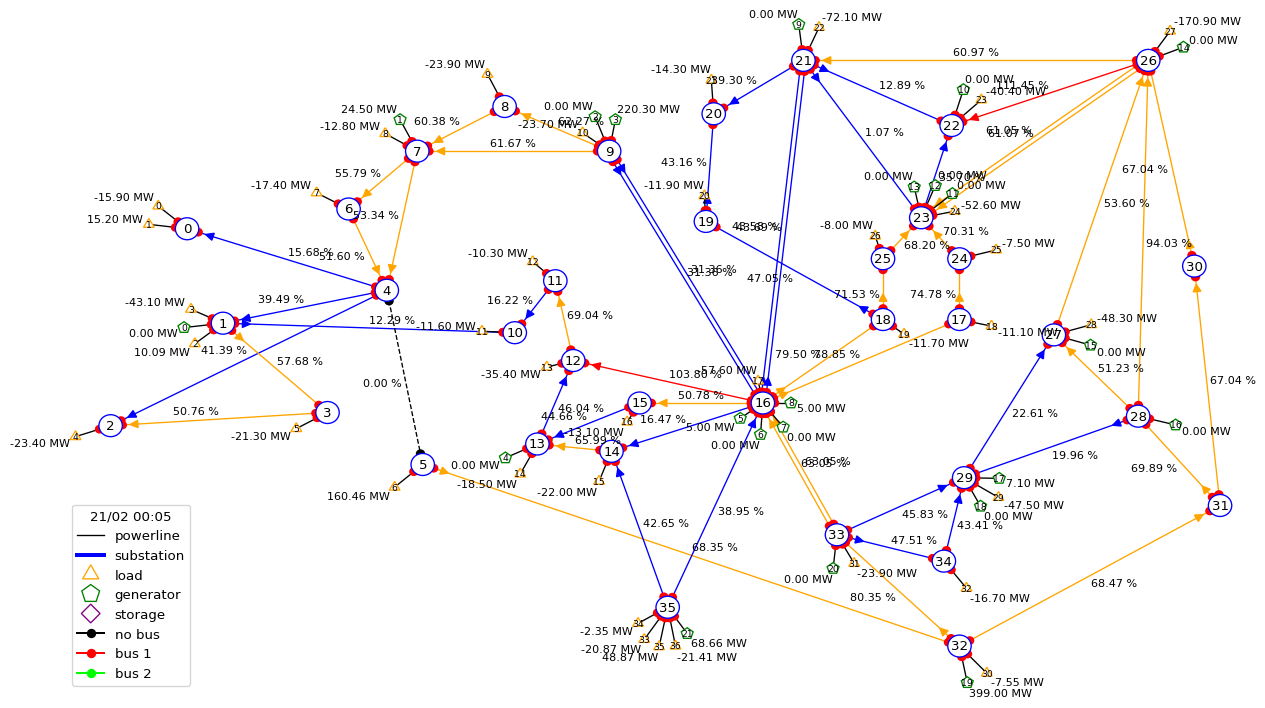

In [75]:
env.set_id(1)
env.seed(1)
obs = env.reset()  # remember we broke everything in our previous demonstration, so we restart properly
_ = plot_helper.plot_obs(obs)
contingency_id = 55
next_obs, reward, done, extra_information = env.step(env.action_space({"set_line_status": 
                                                                       [(contingency_id, -1)]}))
# imagine we are in this state
_ = plot_helper.plot_obs(next_obs)

let's see what happen if we don't do anything.

If i don't do anything i could survive 6 time steps :-(


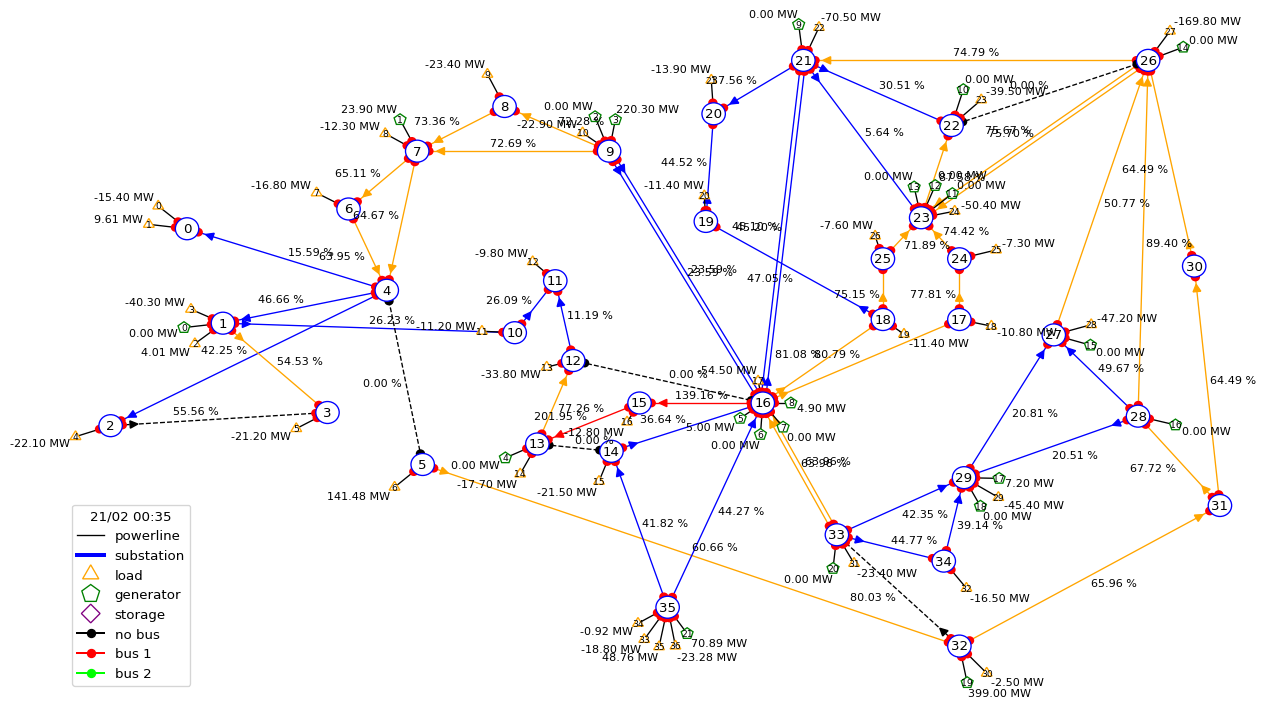

In [76]:
ts_lived = 0
num_step = 0
while not done:
    next_obs, reward, done, extra_information = env.step(do_nothing)
    ts_lived += 1
    num_step += 1
    if max_iter != -1 and num_step > max_iter:
        break
print("If i don't do anything i could survive {} time steps :-(".format(ts_lived))
next_obs.line_status[extra_information["disc_lines"]] = False
_ = plot_helper.plot_obs(next_obs)

##### Let's replay to demonstrate the proper topological action can solve the issue

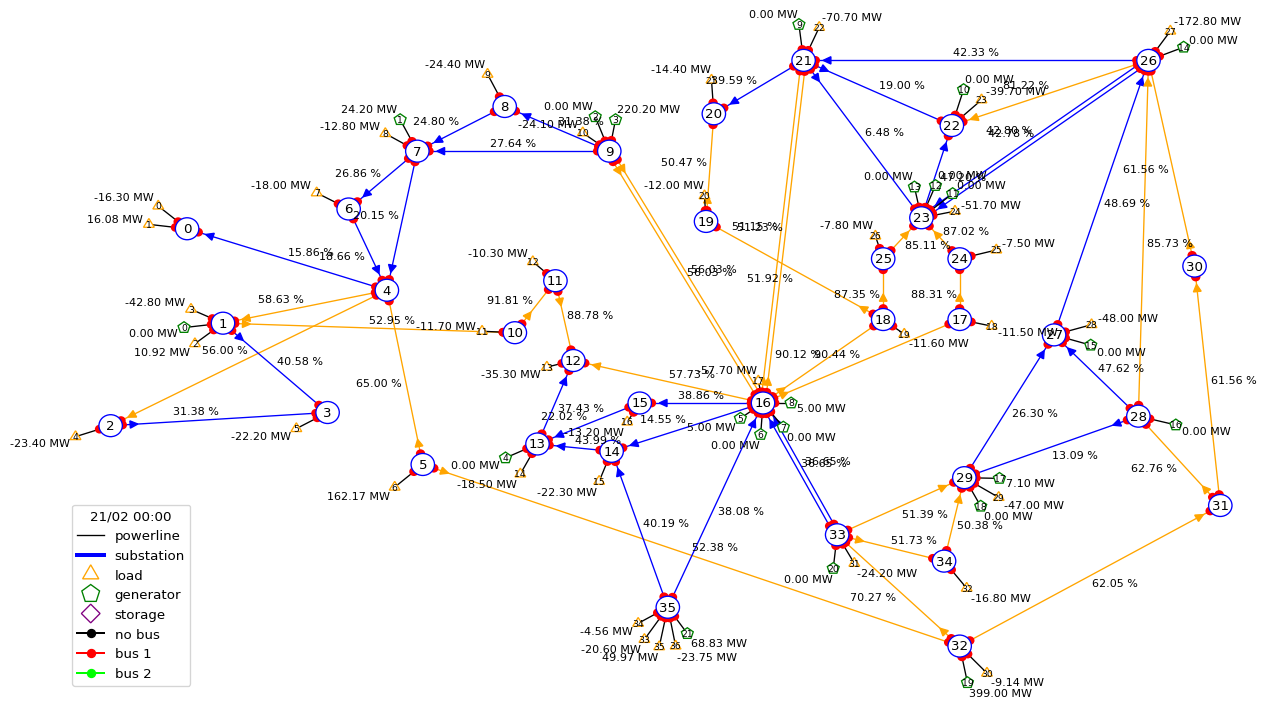

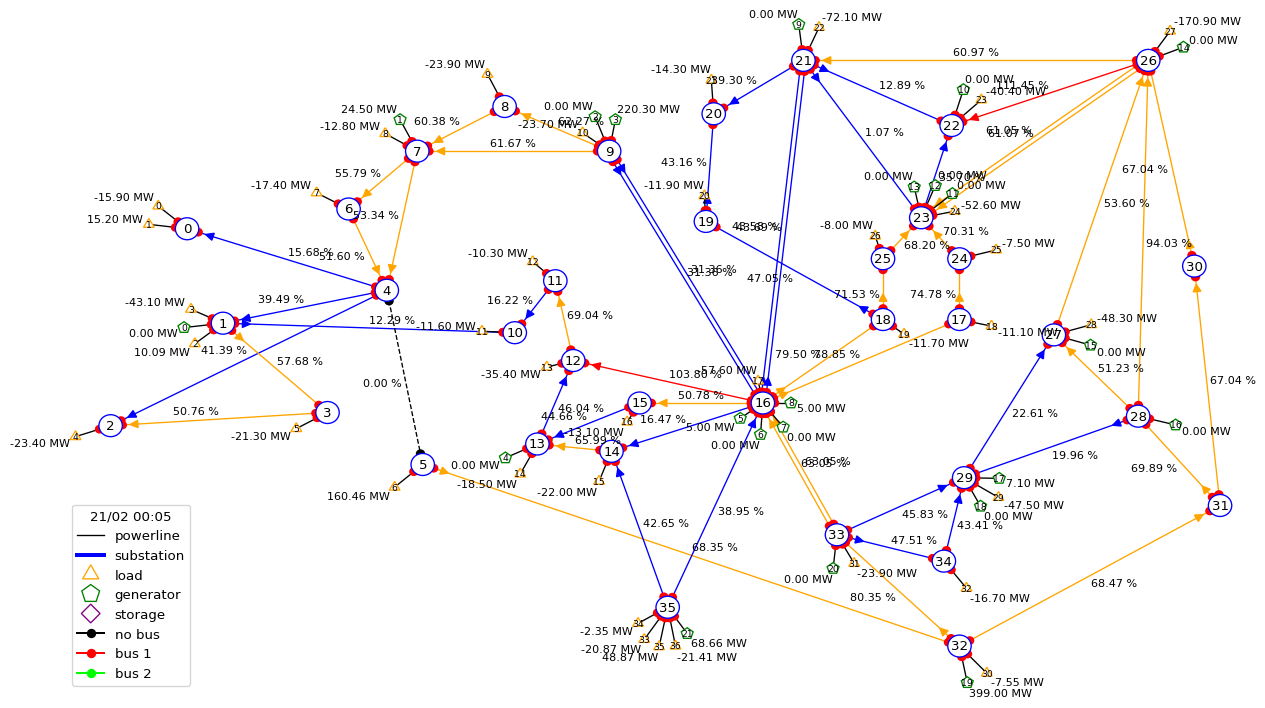

In [97]:
env.set_id(1)
env.seed(1)
obs = env.reset()  # remember we broke everything in our previous demonstration
_ = plot_helper.plot_obs(obs)
next_obs, reward, done, extra_information = env.step(env.action_space({"set_line_status": 
                                                                       [(contingency_id, -1)]}))
# imagine we are in this state
_ = plot_helper.plot_obs(next_obs)

Let's implement the "magic" action now and see what happens.

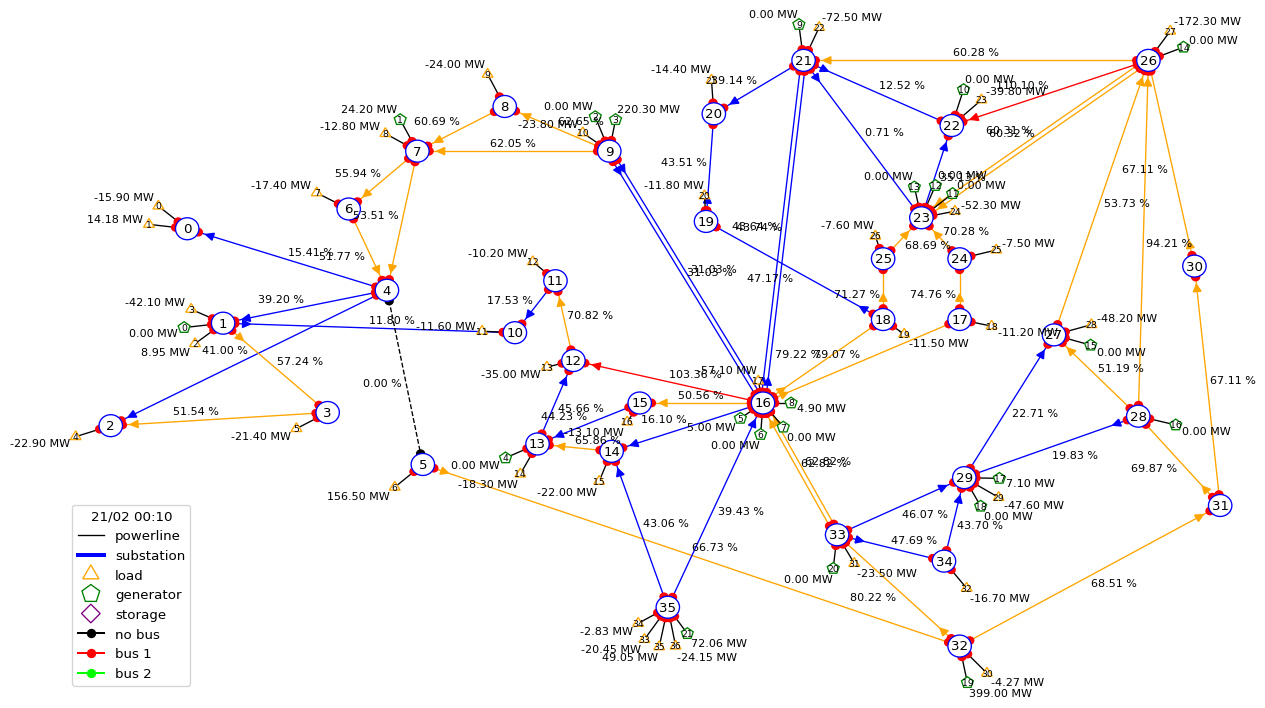

In [98]:
action_saved = env.action_space({"set_bus": {'loads_id': [(30, 1)],  # i want to set to busbar 1 the load of id 6
                                   'generators_id': [(19, 1), (20, 1), (3, 1), (9, 2)]  # busbar 1 for the generator of id 14
                                            }})
                                 
next_obs, reward, done, extra_information = env.step(action_saved)
# imagine we are in this state
_ = plot_helper.plot_obs(next_obs)

If i do the action above i can survive 5 time steps (we stopped the 'game' after 5 time steps)


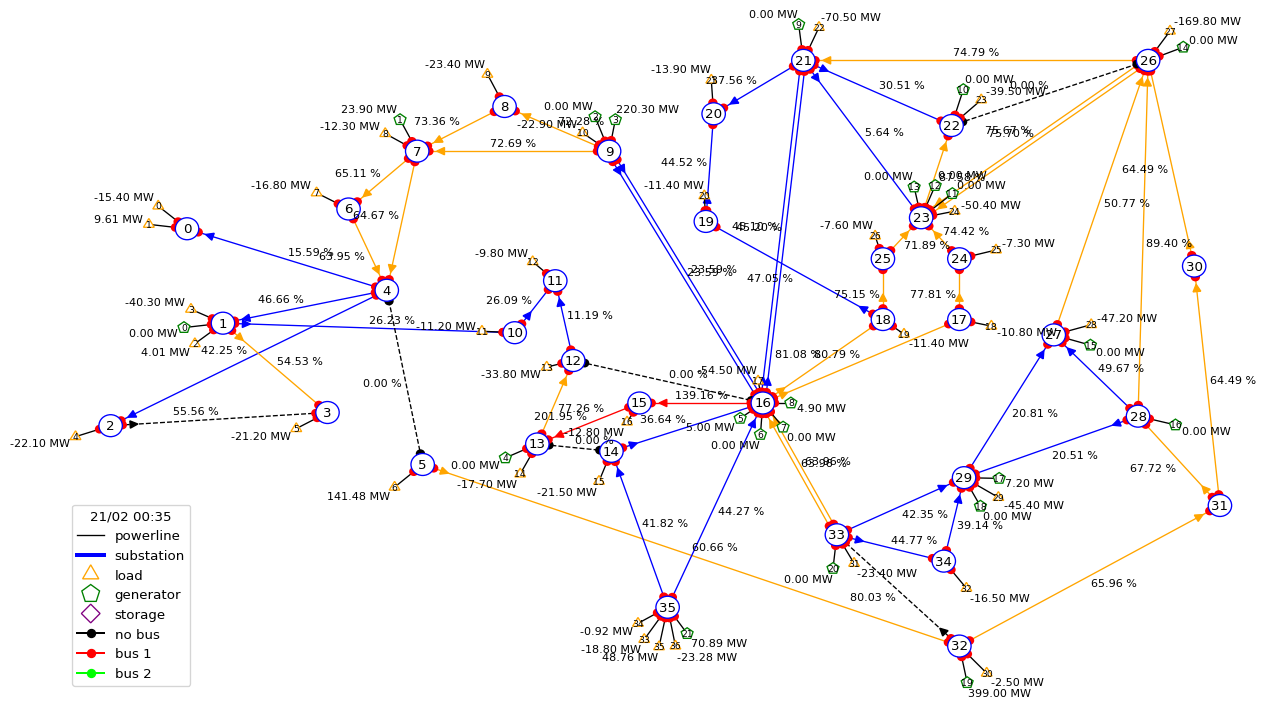

In [99]:
ts_lived_now = 0
while not done:
    next_obs, reward, done, extra_information = env.step(do_nothing)
    ts_lived_now += 1
    if max_iter != -1 and ts_lived_now >= max_iter:
        break
print("If i do the action above i can survive {} time steps (we stopped the 'game' after {} time steps)"
      "".format(ts_lived_now, max_iter))
next_obs.line_status[extra_information["disc_lines"]] = False
_ = plot_helper.plot_obs(next_obs)

Instead of dying after 6 time steps if we do nothing, for the same cost (zero) we can survive at least an 5 (which is worse) time steps 

The elements connected to the substation 26 are: {'loads_id': array([27], dtype=int64), 'generators_id': array([14], dtype=int64), 'lines_or_id': array([40, 41], dtype=int64), 'lines_ex_id': array([36, 37, 38, 39, 56], dtype=int64), 'storages_id': array([], dtype=int64), 'nb_elements': 9}
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element(s):
	 	 - Assign bus 1 to line (extremity) id 36 [on substation 26]
	 	 - Assign bus 2 to line (extremity) id 37 [on substation 26]
	 	 - Assign bus 1 to line (extremity) id 38 [on substation 26]
	 	 - Assign bus 1 to line (extremity) id 39 [on substation 26]
	 	 - Assign bus 1 to line (origin) id 40 [on substation 26]
	 	 - Assign bus 2 to line (origin) id 41 [on substation 26]
	 	 - Assign bus 

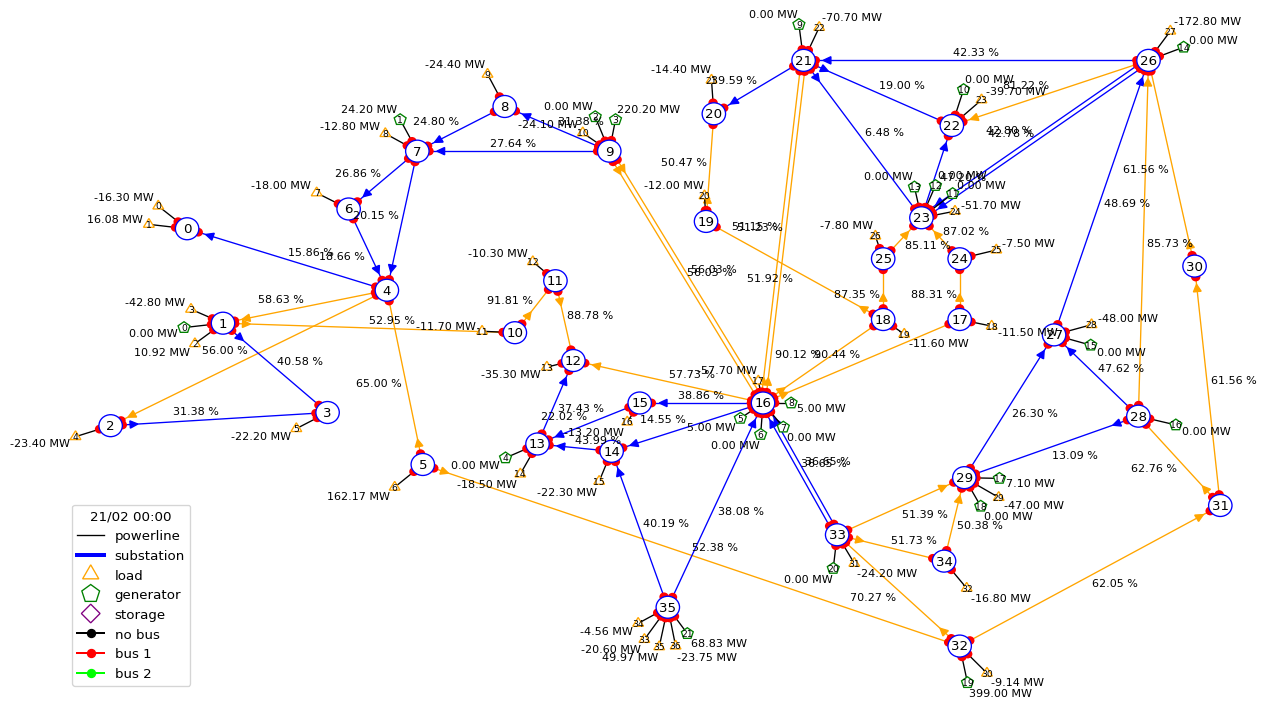

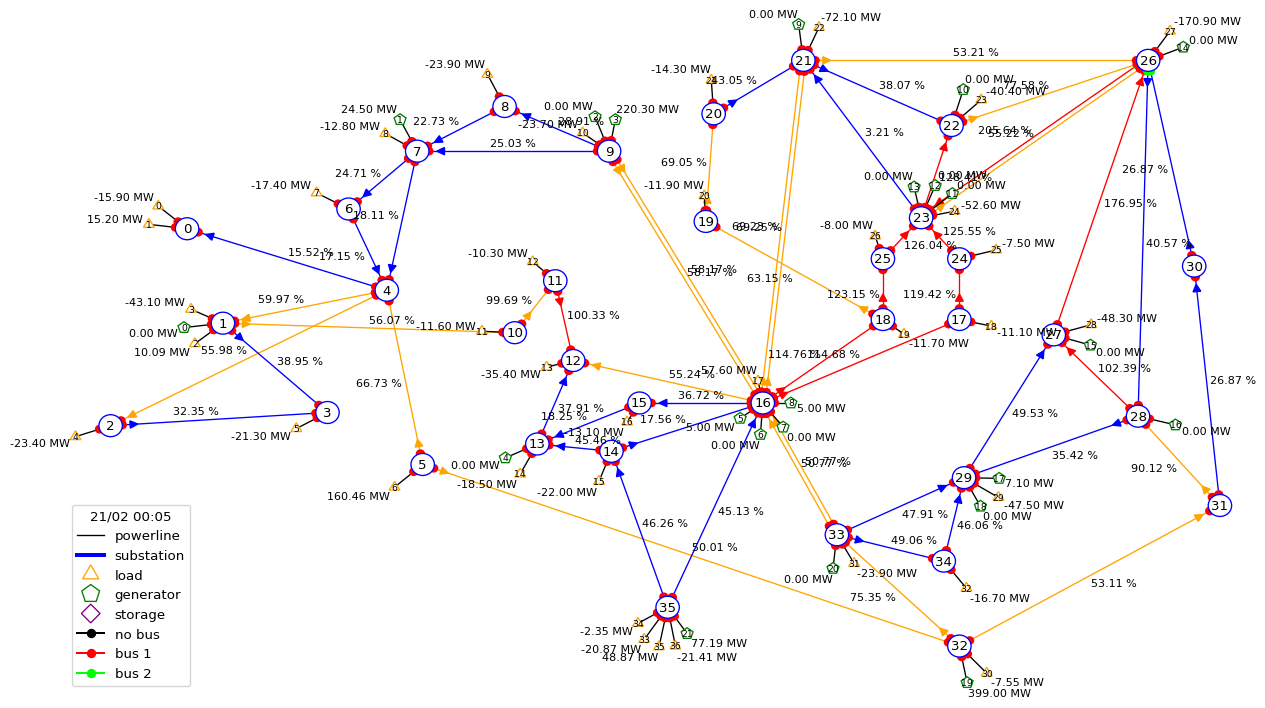

In [100]:
env.set_id(1)  # I am "cheating" a bit, for the demonstration, i specify which chronics i want to study
obs = env.reset()  # remember we broke everything in our previous demonstration
_ = plot_helper.plot_obs(obs)
s_id = 26
print("The elements connected to the substation {} are: {}".format(s_id,
                                                                   env.get_obj_connect_to(substation_id=s_id)))
action = env.action_space({"set_bus": {'loads_id': [(27, 1)],  # i want to set to busbar 1 the load of id 27
                                       'generators_id': [(14, 1)],  # busbar 1 for the generator of id 14
                                       'lines_or_id': [(40, 1), (41, 2)],
                                       'lines_ex_id': [(36, 1), (37, 2), (38, 1), (39, 1), (56, 2)]}})
print(action)
next_obs, reward, done, extra_information = env.step(action)
_ = plot_helper.plot_obs(next_obs)

If i do the action above i can survive 3 time steps (we stopped the 'game' after 5 time steps)


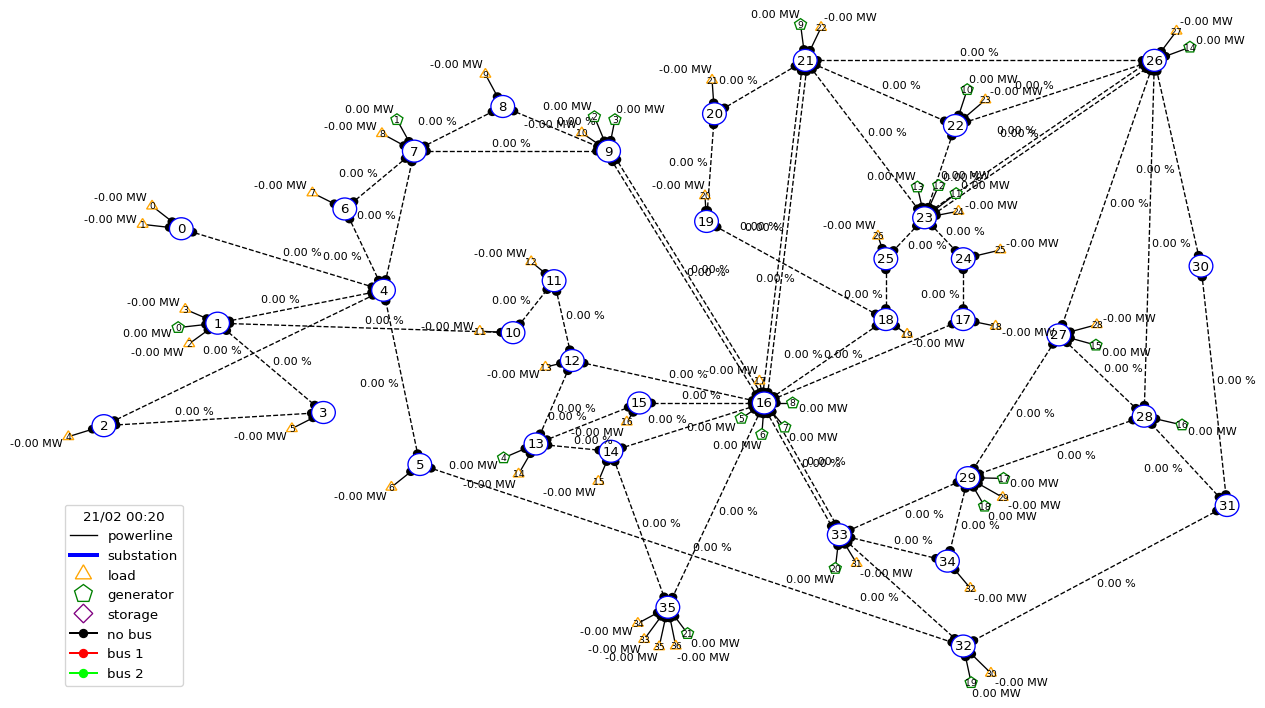

In [101]:
ts_lived_now = 0
while not done:
    next_obs, reward, done, extra_information = env.step(do_nothing)
    ts_lived_now += 1
    if max_iter != -1 and ts_lived_now >= max_iter:
        break
print("If i do the action above i can survive {} time steps (we stopped the 'game' after {} time steps)"
      "".format(ts_lived_now, max_iter))
next_obs.line_status[extra_information["disc_lines"]] = False
_ = plot_helper.plot_obs(next_obs)

### III Redispatching

Remember in our case we suppose that the "market" / "economic dispatch" has been made, each producer know exactly what it will produce exactly for the entire scenario at a 5 mins resolution, and this is "economic dispatch" is supposed to be cost efficient.

Performing a redispatching is telling some producer that they have to increase the production at a given place, and decrease it at another place. This has the consequence to make the grid more costly. Suppose the new situation (after redispatching) was less costly for the producers, when the "economic dispatch" was run, they would bewith this fictive state. This would mean the "market" / "economic dispatch" was not optimal in the first place, which (in our setting) is not possible.

This explains why redispatching action have an intrisic cost. For our competition we decided to penalize redispatching proportionally to the amount of redispatching performed (see the competition description for a more detailed formula).

This entails that, if you redispatch say 10MW you "pay" a cost of 10MW * the marginal cost of the grid (for simplification we say it is the highest cost of the turned on generator at any time).

cost of the action: proportional to amount of energy dispatched

cooldown: none (you can cancel it the next step)

maximum: none (you can act on as many generator as you want)

/!\ /!\ /!\ A redispatching will be "modified" by the environment before being implemented. This is because it must meet really difficult constraint: it should sum to 0, make sure every generator is between pmin and pmax, make sure, for each generator difference between the production at the next time step and the current time step is in a feasible range (ramping). Finally not all generator are dispatchable (solar and wind energy source are not). This can make the implementation of redispatching a bit tricky. /!\ /!\ /!\

Let's now see how it is performed in grid2op.

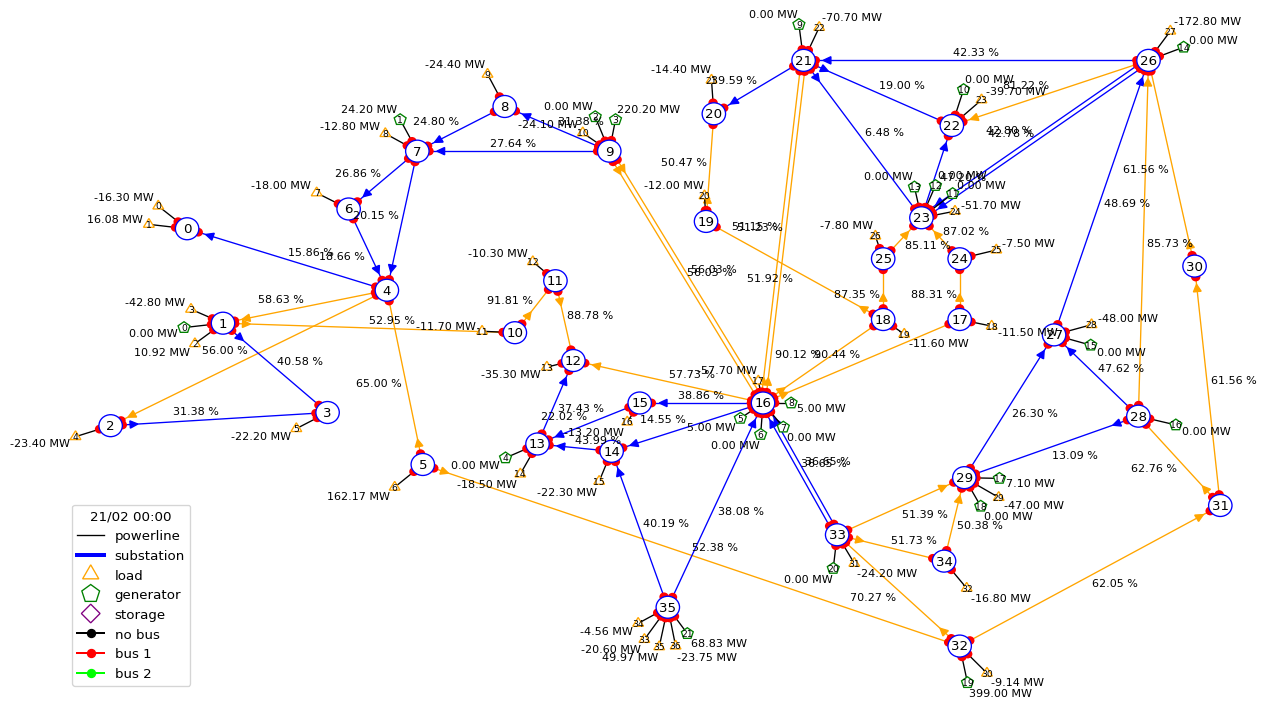

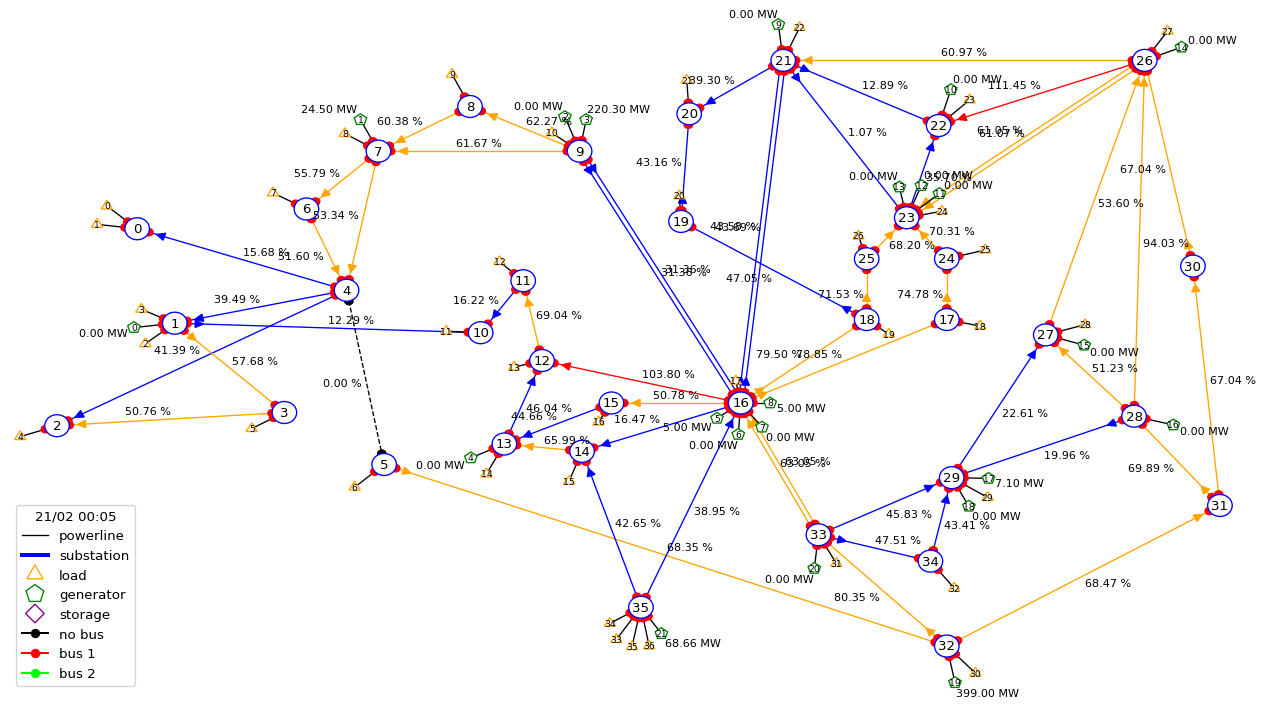

In [102]:
env.set_id(1)
env.seed(1)
obs = env.reset()  # remember we broke everything in our previous demonstration, so we restart properly
_ = plot_helper.plot_obs(obs)
next_obs, reward, done, extra_information = env.step(env.action_space({"set_line_status": 
                                                                       [(contingency_id, -1)]}))
# imagine we are in this state
_ = plot_helper.plot_obs(next_obs, load_info=None)

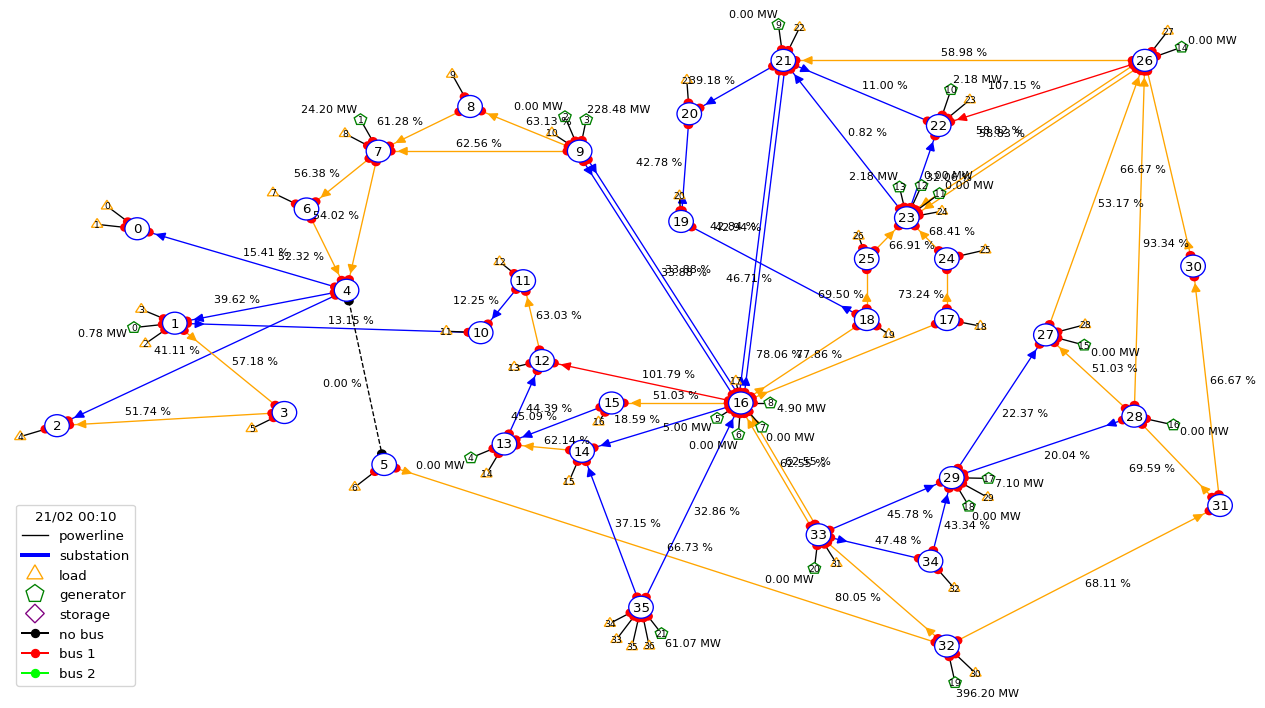

In [103]:
action_redisp = env.action_space({"redispatch": [
    (0, +1.4), (3, +8.8),
    (10, +2.8), (13, +2.8),
    (21, -9.9), (19, -2.8)
]})
next_obs, reward, done, extra_information = env.step(action_redisp)
_ = plot_helper.plot_obs(next_obs, load_info=None)

price_t = np.max(next_obs.gen_cost_per_MW[next_obs.gen_p > 0.]).astype(float)
loss_cost = (np.sum(next_obs.gen_p) - np.sum(next_obs.load_p)) * price_t
resdisp_cost = np.sum(np.abs(next_obs.actual_dispatch)) * price_t

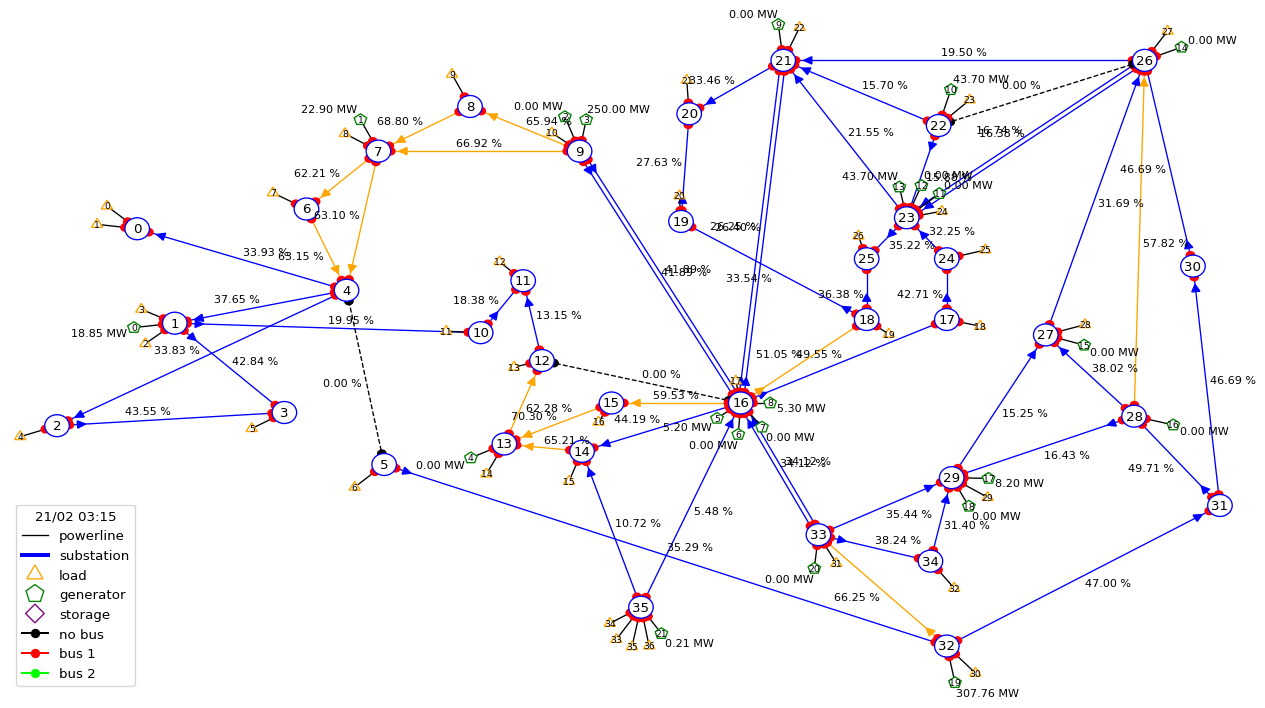

In [112]:
next_obs, reward, done, extra_information = env.step(action_redisp)
_ = plot_helper.plot_obs(next_obs, load_info=None)

price_t = np.max(next_obs.gen_cost_per_MW[next_obs.gen_p > 0.]).astype(float)
loss_cost += (np.sum(next_obs.gen_p) - np.sum(next_obs.load_p)) * price_t
resdisp_cost += np.sum(np.abs(next_obs.actual_dispatch)) * price_t

If i do the action above i can survive 5 time steps (we stopped the 'game' after 5 time steps)


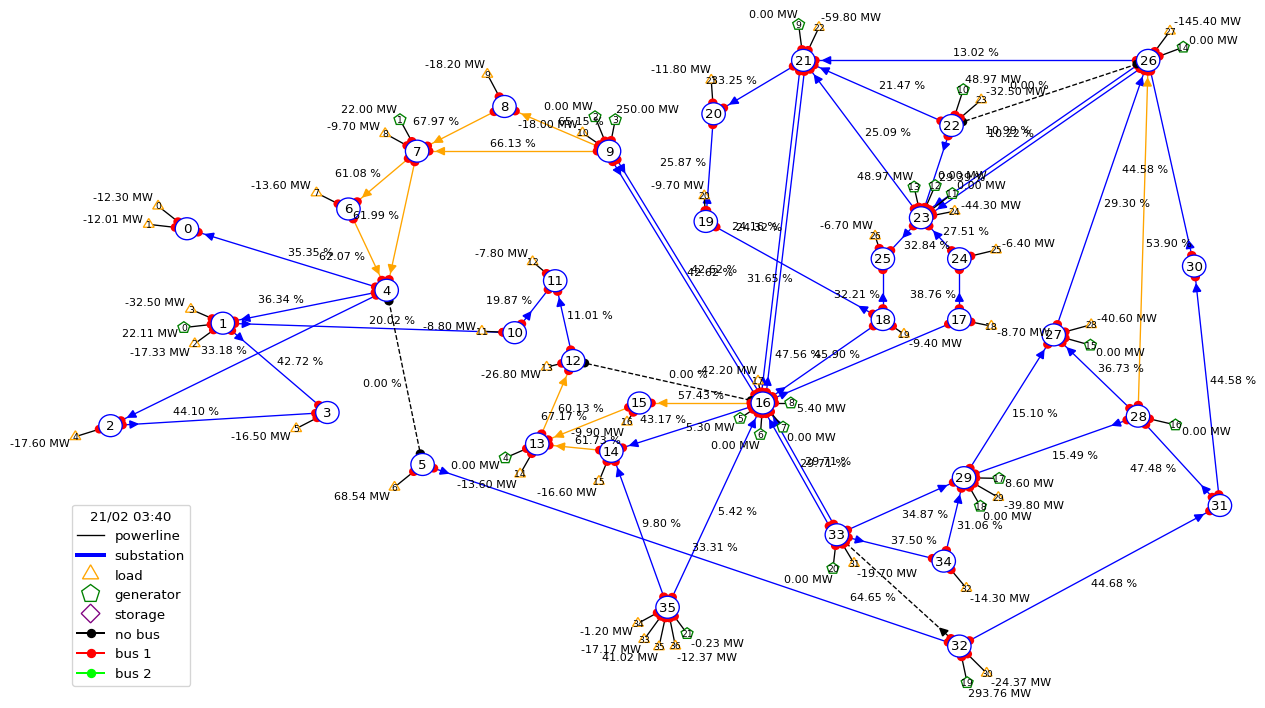

In [113]:
ts_lived_now = 0
while not done:
    next_obs, reward, done, extra_information = env.step(action_redisp)
    ts_lived_now += 1
    if max_iter != -1 and ts_lived_now >= max_iter:
        break
print("If i do the action above i can survive {} time steps (we stopped the 'game' after {} time steps)"
      "".format(ts_lived_now, max_iter))
next_obs.line_status[extra_information["disc_lines"]] = False
_ = plot_helper.plot_obs(next_obs)

A few notes here:

 - the maximum possible for each generator were asked in the action
 - some generator were dispatchable but were not turned off, though they could have helped
 - dispite our effort, no powerlines is "saved"



## Creating an Agent 

In this section we will make our first Agent that will act based on these observations.

Basically, the Agent receives a reward and an observation, and chooses a new action.

This Agent will select among:
 - doing nothing
 - disconnecting the powerline having the higher relative flows
 - reconnecting a powerline disconnected
 - disconnecting the powerline having the lower relative flows

In [114]:
from grid2op.Agent import BaseAgent
import numpy as np


class MyAgent(BaseAgent):
    def __init__(self, action_space):
        # python required method to code
        BaseAgent.__init__(self, action_space)
        self.do_nothing = self.action_space({})
        self.print_next = False
        
    def act(self, observation, reward, done=False):
        i_max = np.argmax(observation.rho)
        new_status_max = np.zeros(observation.rho.shape, dtype=int)
        new_status_max[i_max] = -1
        act_max = self.action_space({"set_line_status": new_status_max})
        
        i_min = np.argmin(observation.rho)
        new_status_min = np.zeros(observation.rho.shape, dtype=int)
        if observation.rho[i_min] > 0:
            # all powerlines are connected, i try to disconnect this one
            new_status_min[i_min] = -1
            act_min = self.action_space({"set_line_status": new_status_min})
        else:
            # at least one powerline is disconnected, i try to reconnect it
            new_status_min[i_min] = 1
#             act_min = self.action_space({"set_status": new_status_min})
            act_min = self.action_space({"set_line_status": new_status_min,
                                         "set_bus": {"lines_or_id": [(i_min, 1)], "lines_ex_id": [(i_min, 1)]}})
    
        _, reward_sim_dn, *_ = observation.simulate(self.do_nothing)
        _, reward_sim_max, *_ = observation.simulate(act_max)
        _, reward_sim_min, *_ = observation.simulate(act_min)
            
        if reward_sim_dn >= reward_sim_max and reward_sim_dn >= reward_sim_min:
            self.print_next = False
            res = self.do_nothing
        elif reward_sim_max >= reward_sim_min:
            self.print_next = True
            res = act_max
        else:
            self.print_next = True
            res = act_min
        return res

The **runner** class aims at:

facilitate the evaluation of the performance of grid2op.Agent by performing automatically the “open ai gym loop” (see below)

define a format to store the results of the evaluation of such agent in a standardized manner

this “agent logs” can then be re read by third party applications, such as grid2viz or by internal class to ease the study of the behaviour of such agent, for example with the classes grid2op.Episode.EpisodeData or grid2op.Episode.EpisodeReplay

allow easy use of parallelization of this assessment.

In [118]:
from grid2op.Runner import Runner
# from grid2op.Agent import DoNothingAgent
from grid2op.Reward import L2RPNReward
from grid2op.Chronics import GridStateFromFileWithForecasts

runner = Runner(**env.get_params_for_runner(),
                agentClass=MyAgent
               )
res = runner.run(nb_episode=1, max_iter=max_iter)
print("The results for the custom agent are:")
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_name)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

The results for the custom agent are:
	For chronics with id Scenario_august_dummy
		 - cumulative reward: 4537.959473
		 - number of time steps completed: 50 / 50


In [119]:
# Comparing this with PowerLineSwitch agent

from grid2op.Agent import PowerLineSwitch
runner = Runner(**env.get_params_for_runner(),
                agentClass=PowerLineSwitch
               )
res = runner.run(nb_episode=1, max_iter=max_iter)
print("The results for the PowerLineSwitch agent are:")
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_name)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

The results for the PowerLineSwitch agent are:
	For chronics with id Scenario_august_dummy
		 - cumulative reward: 708.793152
		 - number of time steps completed: 9 / 50


###  Make an agent (based on NN or DL)

Below we are using DuelQSimple agent from l2rpn_baseline 

### 1) Train an agent

In [121]:
# example of training an agent
from l2rpn_baselines.DuelQSimple import train
from l2rpn_baselines.utils import NNParam, TrainingParam
import shutil

train_iter = 60  # again for time constraints. You should expect a real model to be trained on way more data


agent_name = "test_agent"
save_path = "saved_agent_DDDQN_BDA_{}".format(train_iter)
logs_dir="tf_logs_DDDQN"

# because this notebook is executed often, i clean the "save_path"
shutil.rmtree(save_path, ignore_errors=True)

# we then define the neural network we want to make (you may change this at will)
## 1. first we choose what "part" of the observation we want as input, 
## here for example only the generator and load information
## see https://grid2op.readthedocs.io/en/latest/observation.html#main-observation-attributes
## for the detailed about all the observation attributes you want to have
li_attr_obs_X = ["gen_p", "gen_v", "load_p", "load_q"]
# this automatically computes the size of the resulting vector
observation_size = NNParam.get_obs_size(env, li_attr_obs_X) 

## 2. then we define its architecture
sizes = [300, 300, 300]  # 3 hidden layers, of 300 units each, why not...
activs =  ["relu" for _ in sizes]  # all followed by relu activation, because... why not
## 4. you put it all on a dictionnary like that (specific to this baseline)
kwargs_archi = {'observation_size': observation_size,
                'sizes': sizes,
                'activs': activs,
                "list_attr_obs": li_attr_obs_X}

# you can also change the training parameters you are using
# more information at https://l2rpn-baselines.readthedocs.io/en/latest/utils.html#l2rpn_baselines.utils.TrainingParam
tp = TrainingParam()
tp.batch_size = 32  # for example...
tp.update_tensorboard_freq = int(train_iter / 10)
tp.save_model_each = int(train_iter / 3)
tp.min_observation = int(train_iter / 5)

# which actions i keep (on this small environment i CANNOT train an agent to perform the 66k actions)
kwargs_converters = {"all_actions": None,
                     "set_line_status": False,
                     "change_line_status": True,
                     "change_bus_vect": False,
                     "set_topo_vect": False
                     }
    
train(env,
      name=agent_name,
      iterations=train_iter,
      save_path=save_path,
      load_path=None, # put something else if you want to reload an agent instead of creating a new one
      logs_dir=logs_dir,
      kwargs_archi=kwargs_archi,
      training_param=tp,
      kwargs_converters=kwargs_converters,)

  0%|          | 0/60 [00:00<?, ?it/s]

 33%|███▎      | 20/60 [00:01<00:02, 18.37it/s]

 67%|██████▋   | 40/60 [00:02<00:01, 16.29it/s]

 98%|█████████▊| 59/60 [00:03<00:00, 17.21it/s]

100%|██████████| 60/60 [00:03<00:00, 15.08it/s]

Logs are saved in the "tf_logs_DDDQN" log repository. To watch what happens during training, you can type the command (from a bash command line for example):

tensorboard --logdir='tf_logs_DDDQN'
You can even do it while it's training. Tensorboard allows you to monitor, during training, different quantities, for example the loss of your neural network or even the last number of steps the agent performed before getting a game over etc.

### 2) Evaluate the agent

In [123]:
from l2rpn_baselines.DuelQSimple import evaluate
path_save_results = "{}_results".format(save_path)
shutil.rmtree(path_save_results, ignore_errors=True)
evaluated_agent, res_runner = evaluate(env,
                                       name=agent_name,
                                       load_path=save_path,
                                       logs_path=path_save_results,
                                       nb_episode=2,
                                       nb_process=1,
                                       max_steps=max_iter,
                                       verbose=True,
                                       save_gif=False)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observation (InputLayer)       [(None, 118)]        0           []                               
                                                                                                  
 layer_0 (Dense)                (None, 300)          35700       ['observation[0][0]']            
                                                                                                  
 activation_6 (Activation)      (None, 300)          0           ['layer_0[0][0]']                
                                                                                                  
 layer_1 (Dense)                (None, 300)          90300       ['activation_6[0][0]']           
                                                                                            

episode: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]

Evaluation summary:
chronics at: Scenario_august_dummy	total score: 4274.681152	time steps: 50/50
chronics at: Scenario_february_dummy	total score: 547.739990	time steps: 9/50
The agent played 2 different action
Action with ID 73 was played 57 times
This action will:
	 - NOT change anything to the injections
	 - Modify the generators with redispatching in the following way:
	 	 - Redispatch "gen_41_18" of -1.05 MW
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration
-----------
Action with ID 133 was played 2 times
This action will:
	 - NOT change anything to the injections
	 - Modify the generators with redispatching in the following way:
	 	 - Redispatch "gen_68_37" of 4.95 MW
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anyth

In [124]:
for _, _, score, nb_ts, total_ts in res_runner:
    print("The final score is {:.0f} and {}/{} time steps were successfully performed".format(score, nb_ts, total_ts))

The final score is 4275 and 50/50 time steps were successfully performed
The final score is 548 and 9/50 time steps were successfully performed


### 3 Looking at the results and understanding the behaviour of the Agent

-  Robustness 
-  Adaptibility

### 4 Using grid2viz for analyzing

-  Performance of agent
-  how its performing in critical senarios

### 5 Results and Conclusion